In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("AirlineTweets.csv")

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df = df[['airline_sentiment', 'text']].copy()

In [7]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


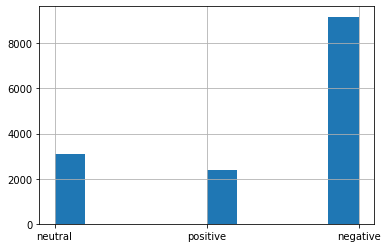

In [8]:
df.airline_sentiment.hist()

In [9]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['target'] = df['airline_sentiment'].map(target_map)

In [10]:
df2 = df[['text', 'target']]
df2.columns = ['sentence', 'label']
df2.to_csv('data.csv', index=None)

In [11]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1a330a011f63eae8/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [14]:
split = raw_dataset['train'].train_test_split(test_size=.3, seed=42)

In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [16]:
# if there are multinle csv files
# load_dataset('csv',  data_files=['file1.csv', 'file2.csv'])

In [17]:
# if there is already train test split
# load_dataset('csv',  data_files={
#                                   'train': ['file1.csv', 'file2.csv'],
#                                   'test': 'test.csv'
#                                  })

In [18]:
checkpoint = 'distilbert-base-cased'

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [21]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

In [22]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [23]:
from transformers import AutoModelForSequenceClassification, \
    AutoConfig, Trainer, TrainingArguments

In [24]:
config = AutoConfig.from_pretrained(checkpoint)

In [25]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 28996
}

In [26]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [27]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [29]:
config.id2label = {v:k for k,v in target_map.items()}
config.label2id = target_map

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [31]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from torchinfo import summary

In [33]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [34]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [35]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels, predictions, average='macro') 
    return {'accuracy': acc, 'f1': f1}

In [36]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [37]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10248
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1923
  Number of trainable parameters = 65783811
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.555100,0.428614,0.829690,0.777246
2,0.343900,0.506039,0.830146,0.780092
3,0.238900,0.656210,0.832650,0.780825


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4392
  Batch size = 64
Saving model checkpoint to training_dir/checkpoint-641
Configuration saved in training_dir/checkpoint-641/config.json
Model weights saved in training_dir/checkpoint-641/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-641/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-641/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation

TrainOutput(global_step=1923, training_loss=0.32957679879460805, metrics={'train_runtime': 188.8463, 'train_samples_per_second': 162.799, 'train_steps_per_second': 10.183, 'total_flos': 388376501242176.0, 'train_loss': 0.32957679879460805, 'epoch': 3.0})

In [38]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [39]:
from transformers import pipeline

In [40]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-1282',
                      device=0)

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {
  "_name_or_path": "training_dir/checkpoint-1282",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 28996
}

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {


In [41]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [42]:
test_pred = savedmodel(split['test']['sentence'])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [43]:
test_pred

[{'label': 'positive', 'score': 0.9336013793945312},
 {'label': 'positive', 'score': 0.9537263512611389},
 {'label': 'positive', 'score': 0.7498485445976257},
 {'label': 'positive', 'score': 0.827085554599762},
 {'label': 'neutral', 'score': 0.9154884815216064},
 {'label': 'negative', 'score': 0.9954437017440796},
 {'label': 'neutral', 'score': 0.9177980422973633},
 {'label': 'neutral', 'score': 0.9833530187606812},
 {'label': 'neutral', 'score': 0.5499528050422668},
 {'label': 'negative', 'score': 0.9957461953163147},
 {'label': 'negative', 'score': 0.9824783205986023},
 {'label': 'negative', 'score': 0.9939814209938049},
 {'label': 'positive', 'score': 0.931094229221344},
 {'label': 'negative', 'score': 0.9790027737617493},
 {'label': 'neutral', 'score': 0.9882832765579224},
 {'label': 'positive', 'score': 0.6564459800720215},
 {'label': 'negative', 'score': 0.6286470890045166},
 {'label': 'negative', 'score': 0.9961387515068054},
 {'label': 'negative', 'score': 0.9328294992446899},


END